In [1]:
import imageio
import skimage
import sklearn.model_selection
import skimage.color
import skimage.transform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import glob
from PIL import Image, ImageOps
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
import imageio
import cv2
import torch.optim as optim
import torch.nn.functional as F
from scipy import signal
from scipy.ndimage import rotate, zoom

%matplotlib inline

# Homework 4

## Problem 1. Detecting Objects with Template Matching

#### Cross-Correlation Filter
Read in image birds1.jpeg and template template.jpeg and convert
each to grayscale. Perform cross-correlation on the image with the template and display the resulting image along with a colorbar. *If you like, you may use scipy library convolution or correlation functions to perform your sliding-window operation with the template, but you cannot use OpenCV matchTemplate.*


In [7]:
from google.colab import files
uploaded = files.upload()

Saving birds5.jpg to birds5.jpg


<ipython-input-8-b0a0335e1a0c>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('birds1.jpeg')
<ipython-input-8-b0a0335e1a0c>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  template = imageio.imread('template.jpeg')


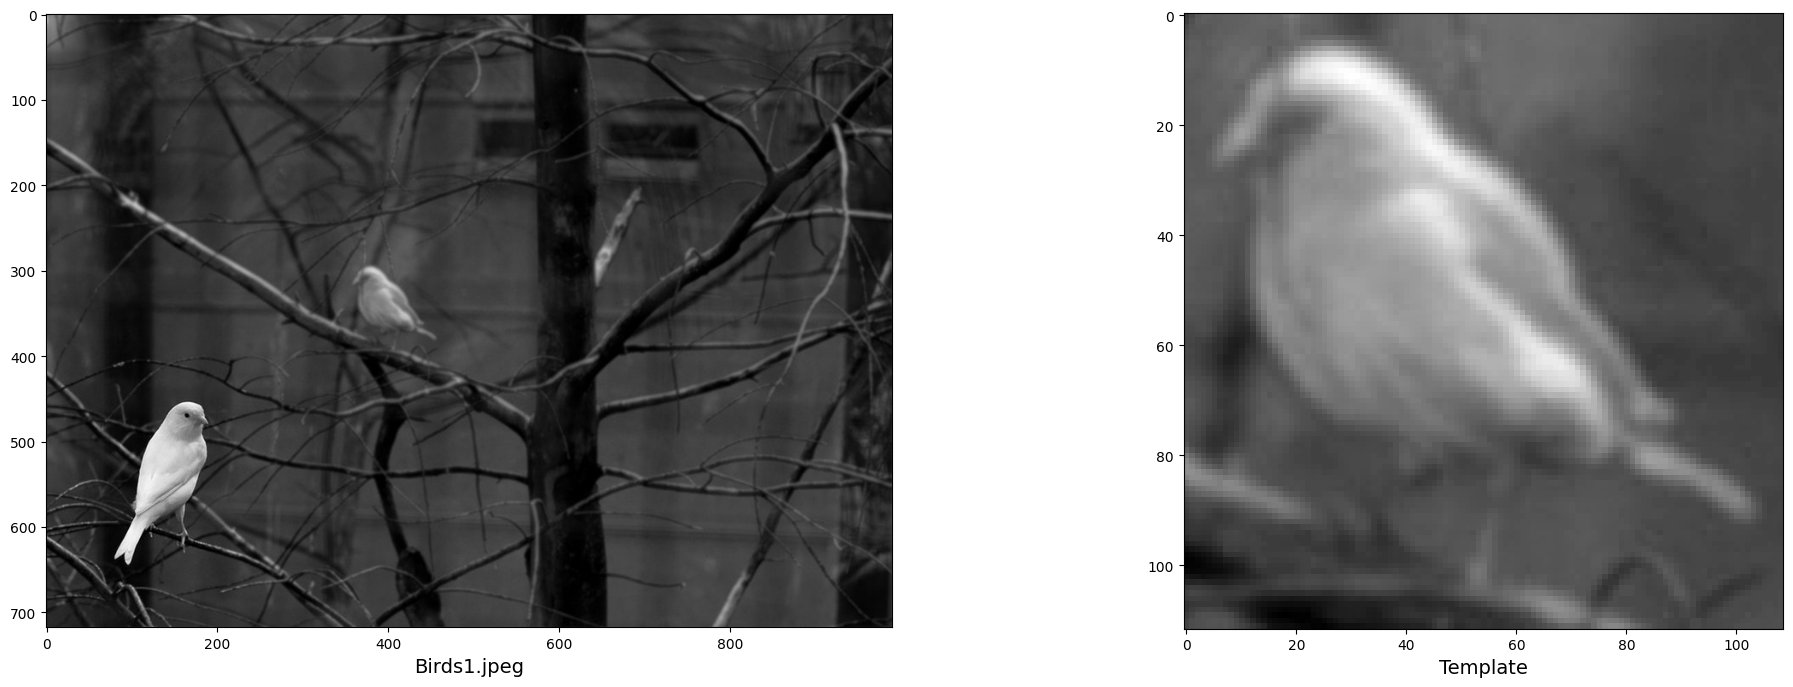

In [8]:
img = imageio.imread('birds1.jpeg')
template = imageio.imread('template.jpeg')

def to_grayscale(image):
  converted = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  return converted

bird = to_grayscale(img)
template_gray = to_grayscale(template)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
ax1.imshow(bird, cmap='gray')
ax1.set_xlabel("Birds1.jpeg", fontsize=14)

ax2.imshow(template_gray, cmap='gray')
ax2.set_xlabel("Template", fontsize=14)

plt.show()

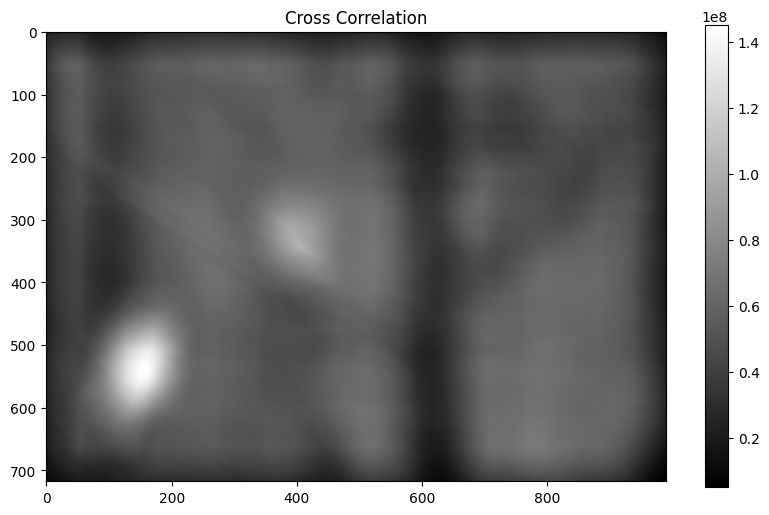

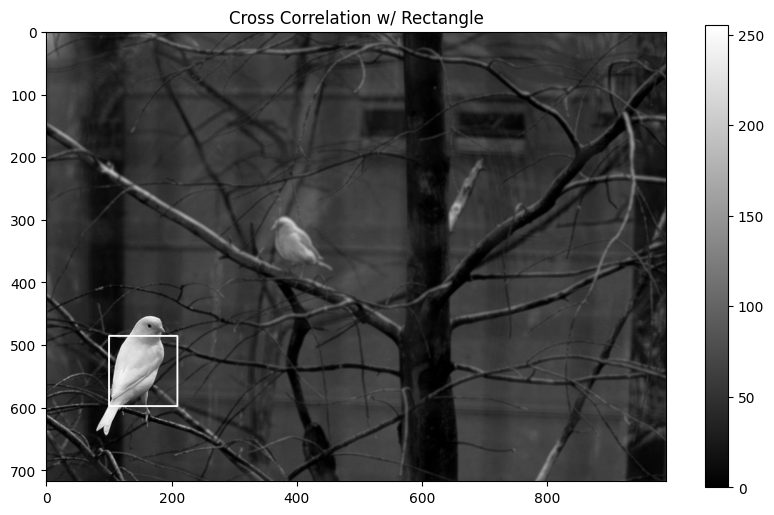

In [11]:
def cross_correlation(img1, img2, mode):
  image1 = np.array(img1, dtype=np.float32)
  image2 = np.array(img2, dtype=np.float32)

  correlation = signal.correlate2d(image1, image2, mode)
  return correlation

def to_array(image):
  converted = np.array(image)
  return converted

def display_rectangle(image, top_left, template_size):
    x, y = top_left
    h, w = template_size

    img_copy = image.copy() if isinstance(image, np.ndarray) else np.array(image) #making a copy of the original image

    img_with_rect = cv2.rectangle(img_copy, (y, x), (y + w, x + h), (255, 0, 0), 2)
    return img_with_rect


correlation = cross_correlation(to_array(bird), to_array(template_gray), mode='same')

max_loc = np.unravel_index(np.argmax(correlation), correlation.shape)
template_h, template_w = to_array(template_gray).shape

# making sure that the top left corner is aligned with the template
# this is just to fix the slightly off centered rectangles being drawn.
x = max_loc[0] - template_h // 2
y = max_loc[1] - template_w // 2

x = max(x, 0) # this is to avoid negative values
y = max(y, 0)

img_with_box = display_rectangle(bird, (x, y), (template_h, template_w))

plt.figure(figsize=(10, 6))
plt.title("Cross Correlation")
plt.imshow(correlation, cmap='gray')
plt.colorbar()

plt.figure(figsize=(10, 6))
plt.title("Cross Correlation w/ Rectangle")
plt.imshow(img_with_box, cmap='gray')
plt.colorbar()

plt.show()


#### Normalized Cross-Correlation
Apply normalized cross-correlation on birds1.jpeg using template.jpeg and display the resulting image with a colorbar. Also, display the original image with a rectangular box (the same size as the template) at the location with the highest normalized cross-correlation score. *In class, we discussed the ambiguity of the term 'normalization'. You may select any normalization method covered in class, but please explain which method you used in 1-2 sentences.*


Next, apply normalized cross-correlation using template.jpeg on birds2.jpeg, birds3.jpeg, birds4.jpeg, and birds5.jpeg. Display the resulting image with a colorbar. Like before, display the original image with a
rectangular box at the location with the highest normalized cross-correlation score. Does the box surround any of the birds? In which cases does the algorithm succeed, and in which does it fail, and why?

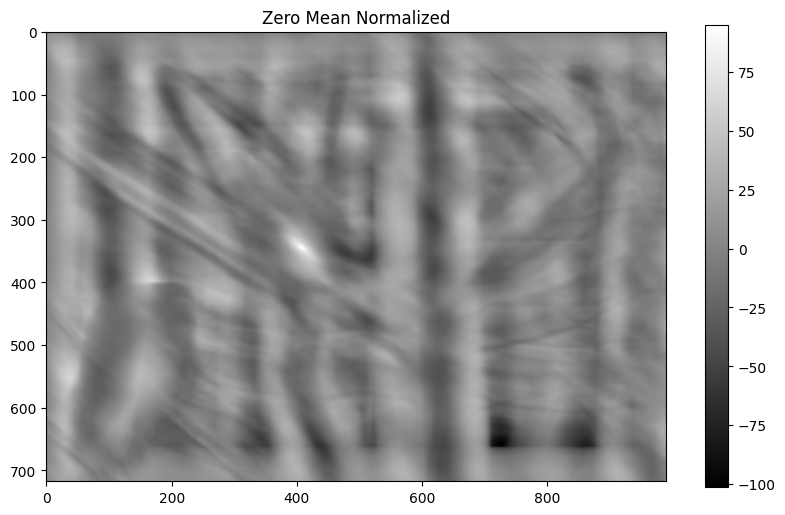

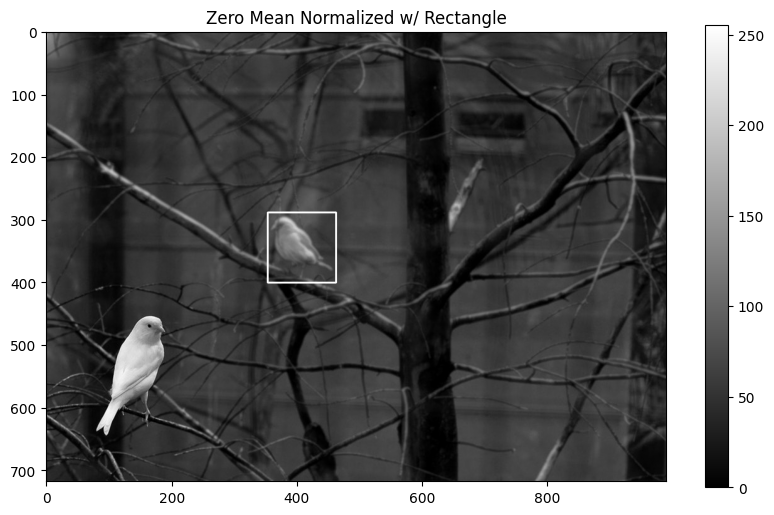

In [12]:
# using zero-mean normalization
def correlation_normalized(image1, image2, mode='same'):
    img1 = np.array(image1, dtype=np.float32)
    img2 = np.array(image2, dtype=np.float32)

    # normalizing the template image
    img2_mean = np.mean(img2)
    img2_std = np.std(img2)
    img2_normalized = (img2 - img2_mean) / (img2_std + 1e-5)

    # calculating the local means and standard deviations of the base image
    local_mean = signal.convolve2d(img1, np.ones(img2.shape) / img2.size, mode=mode)
    local_sqr_mean = signal.convolve2d(img1**2, np.ones(img2.shape) / img2.size, mode=mode)
    local_std = np.sqrt(local_sqr_mean - local_mean**2)

    correlation = signal.correlate2d(img1 - local_mean, img2_normalized, mode=mode) # the correlation calculations
    normalization = correlation / (local_std * np.sqrt(img2.size) + 1e-5)

    return normalization


normalization_1 = correlation_normalized(to_array(bird), to_array(template_gray), mode='same')

max_loc = np.unravel_index(np.argmax(normalization_1), normalization_1.shape)
template_h, template_w = to_array(template_gray).shape

x = max_loc[0] - template_h // 2
y = max_loc[1] - template_w // 2

x = max(x, 0)
y = max(y, 0)

img_with_box = display_rectangle(bird, (x, y), (template_h, template_w))

plt.figure(figsize=(10, 6))
plt.imshow(normalization_1, cmap='gray')
plt.title("Zero Mean Normalized")
plt.colorbar()

plt.figure(figsize=(10, 6))
plt.imshow(img_with_box, cmap='gray')
plt.title("Zero Mean Normalized w/ Rectangle")
plt.colorbar()

plt.show()

<ipython-input-13-12bddbb340a7>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img)


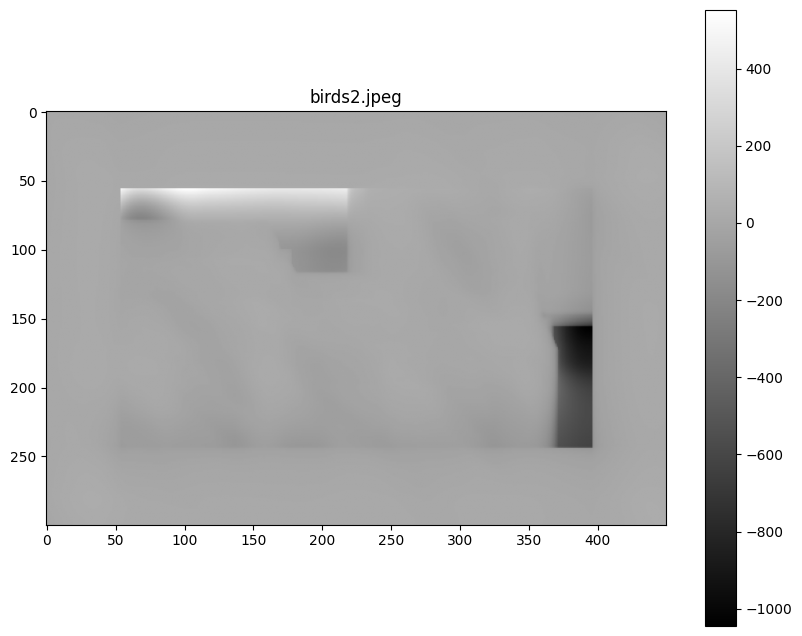

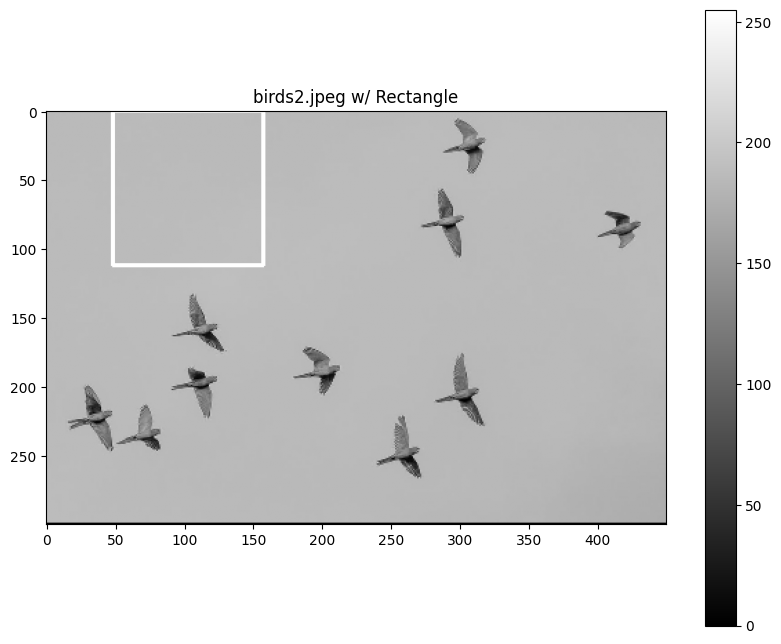

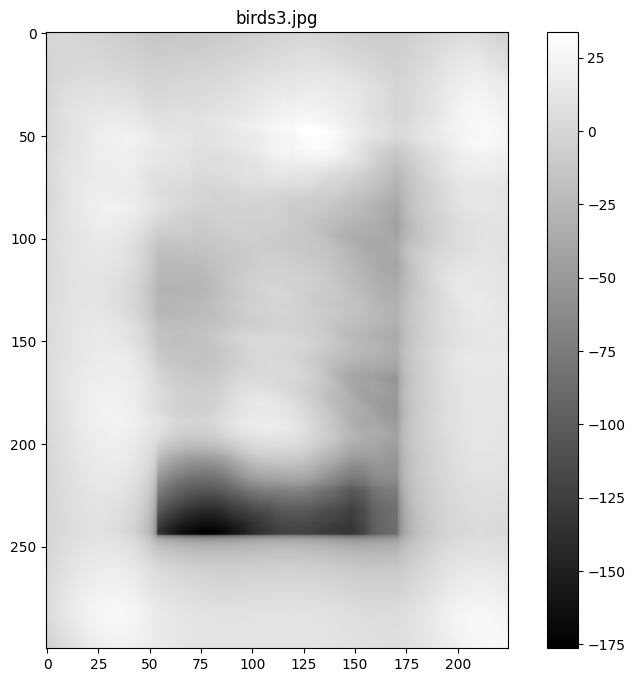

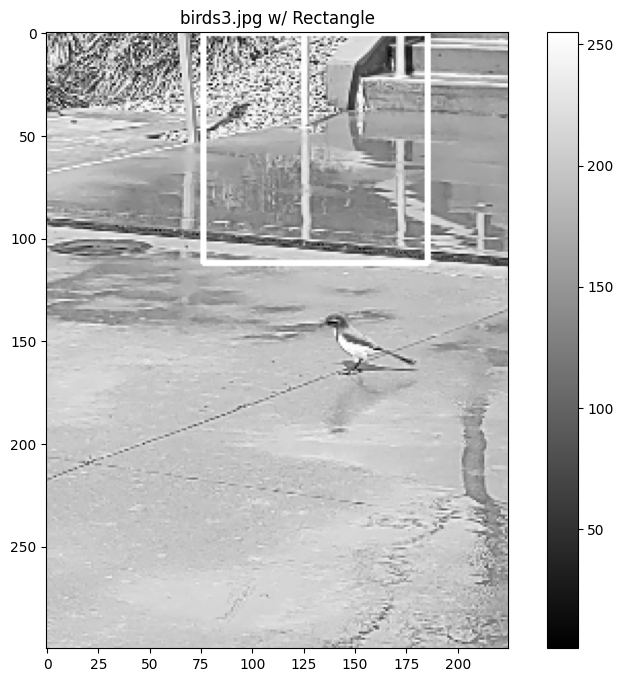

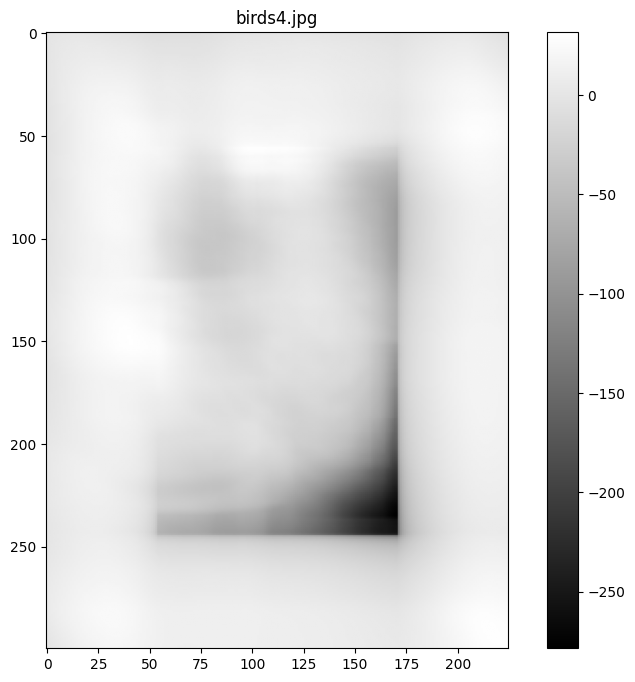

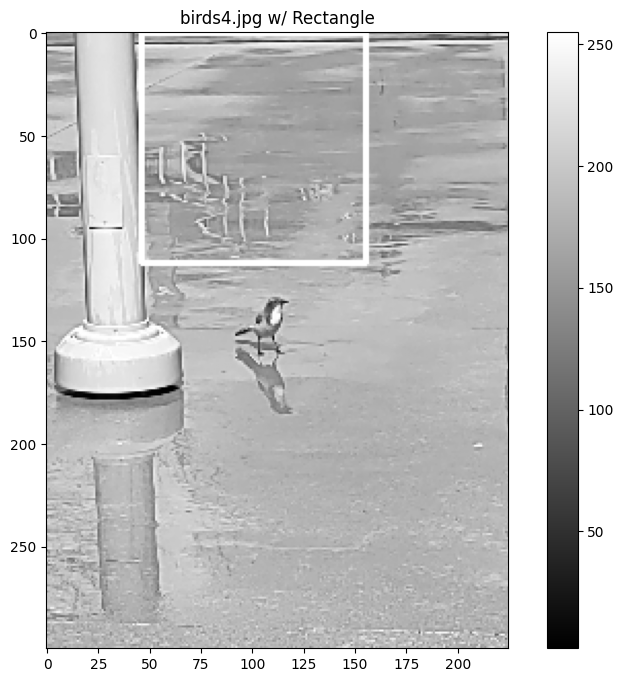

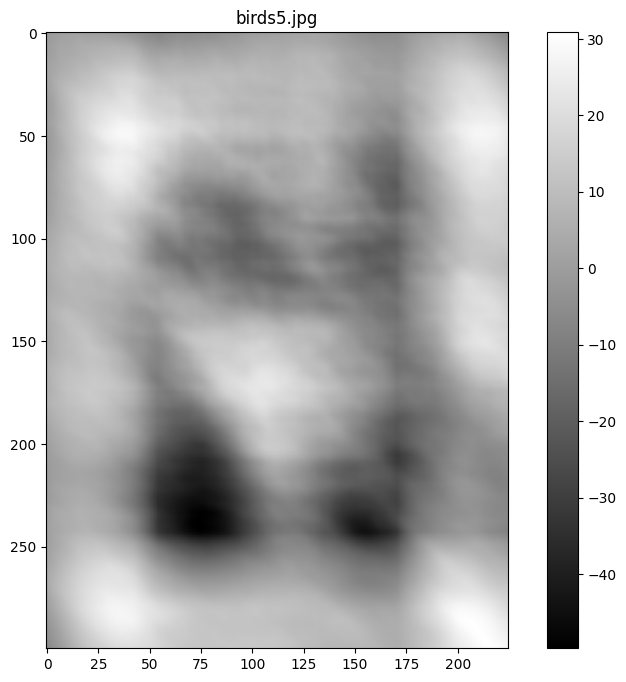

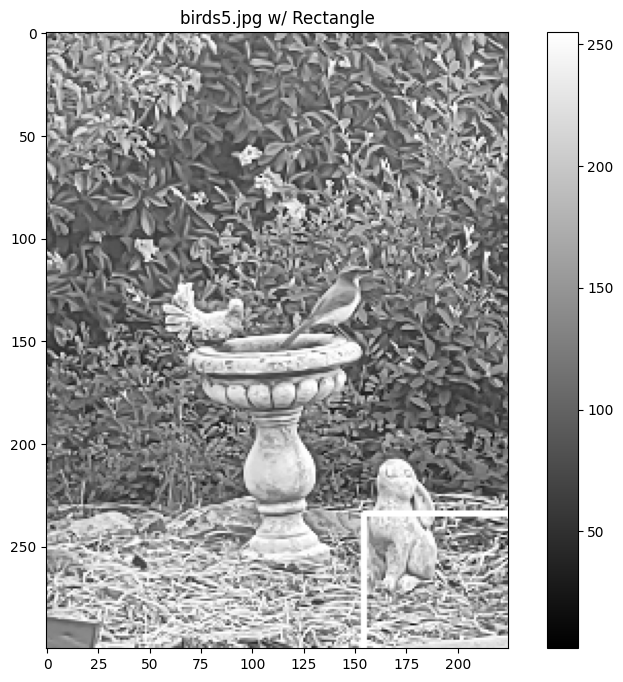

In [13]:
# due to birds3, birds4, and birds5 being like 100x the size of birds1 and birds2, I made this resizing function so that it doesnt take 30+ minutes to run the program for each larger image.
# resources: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html, https://medium.com/tomtalkspython/scipy-for-image-processing-c823b5c0b96b
def resize_image(image_array, target_height=300):
    h, w = image_array.shape[:2]
    zoom_factor = target_height / h

    if image_array.ndim == 3: # if it has 3 dimensions, then use a 3 dimension zoom
        return zoom(image_array, (zoom_factor, zoom_factor, 1))
    else:
        return zoom(image_array, (zoom_factor, zoom_factor))  # else just use a 2d one

img_list = ['birds2.jpeg', 'birds3.jpg', 'birds4.jpg', 'birds5.jpg']

for img in img_list:
    image = imageio.imread(img)

    if img in ['birds3.jpg', 'birds4.jpg', 'birds5.jpg']: # rotating these ones so that theyre vertically aligned.
        image = rotate(image, -90, reshape=True)

    image = resize_image(image, target_height=300)
    grayscale = to_grayscale(image)

    normalization = correlation_normalized(to_array(grayscale), to_array(template_gray), mode='same')
    max_loc = np.unravel_index(np.argmax(normalization), normalization.shape)
    template_h, template_w = to_array(template_gray).shape

    x = max_loc[0] - template_h // 2
    y = max_loc[1] - template_w // 2

    x = max(x, 0)
    y = max(y, 0)

    img_with_box = display_rectangle(grayscale, (x, y), (template_h, template_w))

    plt.figure(figsize=(10, 8))
    plt.imshow(normalization, cmap='gray')
    plt.title(f"{img}")
    plt.colorbar()

    plt.figure(figsize=(10, 8))
    plt.imshow(img_with_box, cmap='gray')
    plt.title(f"{img} w/ Rectangle")
    plt.colorbar()
    plt.show()

# Normalization method: Zero Mean Normalization.

#I chose to use zero mean normalization because it works well with changes in brightness across the image. It allows for the normalization of the mean of patches in the image, which therefore prevents the program from just choosing the brightest area as the predicted location of the template.

#Results:

#In the subsequent images (birds2, 3, 4, 5), no birds were detected by the rectangle. This could be due to the lighting and contrast of the images, or due to the variations in the position or type of the birds. For example, birds2 shows a flock of birds flying in a very different position than the template image. In birds3, there are all sorts of reflections and a different type of bird entriely. These differences in scene and bird could cause the correlation function to mess up.

## Problem 2: Classification with a Convolutional Neural Network

Recall from class the conceptual workflow for supervised machine learning:
- First, we create a <em>training dataset</em>, a paired collection of raw data and labels, where the labels contain information about the information we wish to extract from the raw data.
- Once we have training data, we can then use it to train a <em>model</em>. The model is a function which takes in data and transforms it into an output. The model has some parameters that we can algorithmically adjust to change how it performs this mapping.
- Adjusting these parameters to produce outputs that we want is called training the model. To do this we need two things. First, we need a notion of what we want the output to look like. This notion is captured by a <em>loss function</em>, which compares model outputs and labels and produces a score telling us if the model did a "good" job or not on our given task. By convention, low values of the loss function's output (e.g. the loss) correspond to good performance and high values to bad performance. We also need an <em>optimization algorithm</em>, which is a set of rules for how to adjust the model parameters to reduce the loss.
- Using the training data, loss function, and optimization algorithm, we can then train the model.
- Once the model is trained, we need to evaluate its performance to see how well it performs and what kinds of mistakes it makes. It is important to perform this kind of monitoring during training on a separate "validation" dataset.

The next two problems will let us apply this workflow to the problems of image classification and semantic segmentation. For this first problem, we will train a convolutional neural network (also referred to as a ConvNet or CNN) for an image classification task and evaluate the performance of our trained model. In our case we will be determining which type of street sign is present in a given image.

The foundation of machine learning is data. For this assignment, we will be using the [INI German Traffic Sign Recognition Benchmark](https://benchmark.ini.rub.de/gtsrb_dataset.html) training dataset from [this link](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip). Download and extract the folder to your working directory. *Note: you may need to move the README.txt to a new location to avoid conflict when reading data using the code provided in the Jupyter notebook (though you are welcome to modify the code, too).*

This dataset contains tens of thousands of images of German street signs. How many different types of street signs are included in the dataset? Please display at least 2 different types of signs.



In [ ]:
!unzip GTSRB-Training_fixed.zip -d GTSRB-Training_fixed/

#There are 43 different classes of signs in the dataset (counting from class 0 to 42)

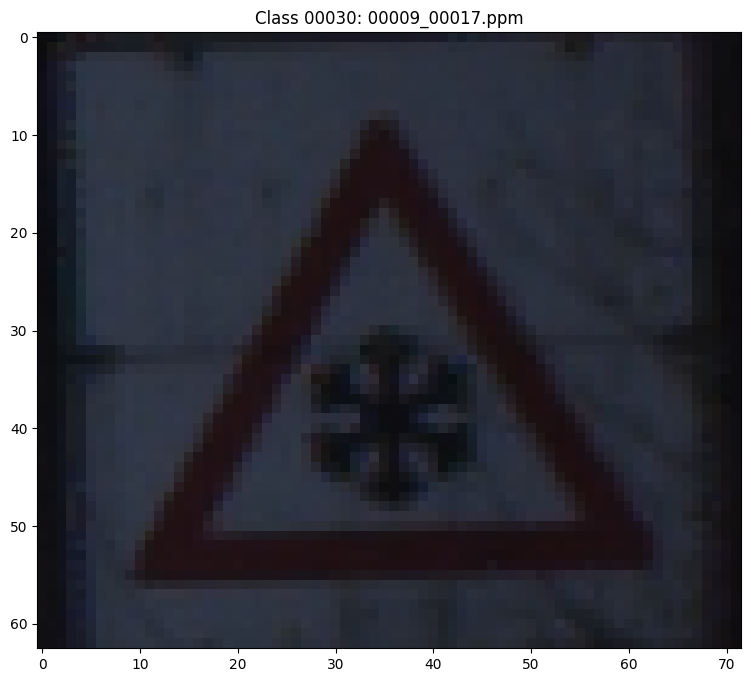

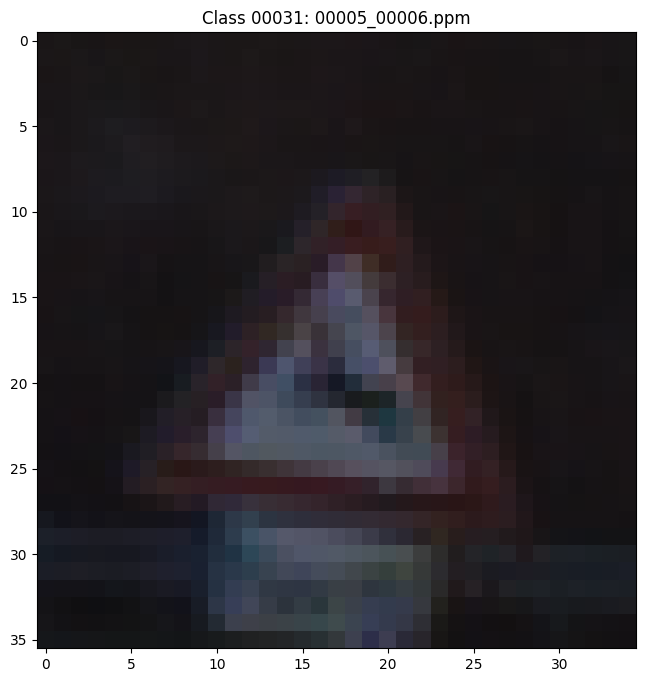

In [ ]:
import random

different_signs_directories = ['00030', '00031'] # choosing images from the 30th class and the 31st class
for x in different_signs_directories:
  directory = f'GTSRB-Training_fixed/GTSRB/Training/{x}/'

  image_files = [os.path.join(directory, f) for f in os.listdir(directory)
                if os.path.isfile(os.path.join(directory, f)) and f.lower().endswith(('.ppm'))]

  selected_images = random.sample(image_files, 1) #grabbing a random image from the directory

  plt.figure(figsize=(10, 8))

  # Display each image
  for i, img_path in enumerate(selected_images):
      img = Image.open(img_path)
      plt.imshow(img)
      plt.title(f"Class {x}: {os.path.basename(img_path)}")

  plt.show()

In this example, there are around 50,000 dataset images available. For now, we will explore the effects of limited data. Begin by loading only 10 images per class (as opposed to the entire dataset) to the variable used to hold all of the image data. *You will need to interpret the below code to find the relevant section. As you complete subproblems requiring repeated experiments, you may want to duplicate and modify the code cell, or make your modifications in-place, noting prior experiment results in the report and adding comments to note where modifications are made.*

**Resizing Data**: We resize all of the images as a preprocessing step to ensure the size of the image matches the size expected by the model. Explain the purpose of the interpolation argument in the resize function.





# Resizing Data: The prupose of the interpolation parameter in cv2.resize() is to determine how pixel values are calculated when added or removed from the image. Essentially, its used to upscale or downscale images to match the desired output size.

**Shuffling and Splitting Data:** Why do we split data into train, validation, and test sets? How many images do we include in each of the sets? Why do we shuffle list\_images prior to splitting?



#Training set: the data that is actually used in the learning process by the model.

#Validation set: The data that the model cross checks during training to make sure that it knows the true labels of the same objects. Pretty much just used to validate its own answers that it got during training. This helps tune the hyperparameters.

#Test set: a different set that isnt available to cross check during training that is designed to test how well the model actually learned. This is only used after training.

#Training set size: 60% of the dataset
#Validation set size: 20% of the dataset
#Test set size: Length of the dataset - the size of the training set - the size of the validation set.

#We shuffle the images in the dataset before adding them to the different subsets so that each set gets a good spread of information. For example, if you just put them into the subsets in order, one set could be missing a type of object that appeared earlier on, etc. Shuffling ensures a good mixture of data in each set.

**Model Details:** There are many considerations to make when designing a neural network. In this problem, a model has been provided for you. Read the provided code, then answer the following questions. Be thorough in your answers; don't just tell us what an acronym stands for - explain the term.

1. What is a convolutional layer?
2. In the provided code, what do each of the arguments passed to Conv2d do?
3. What is maxpooling?
4. What is a dense layer? How is it different from a convolutional layer?
5. What is an epoch?
6. Which loss function do we use in this problem? Explain why this loss function is appropriate for the problem we are solving.
7. Create a diagram of the neural network model (either by hand or using software). The diagram should be detailed enough that another programmer would be able to recreate the model using a deep-learning library. Such diagrams are commonly used in ML research papers to communicate network architectures without verbose code.

#1. A convulutional layer processes images with spatial dimensions by sliding small filters over the image. Each filter captures local features like edges, corners, or textures, then it outputs a feature map that retains the spatial structure of the original.

#2. The first parameter is the amount of channels of the original image. If an image is in RGb format, for example, there should be 3 channels.

#The second paramter is the amount of channels that you want the output image to have. Its pretty much the amount of kernals or filters you want to apply to the image.

#The third paramter is the size of the kernals. In the code, its set to 3, meaning that the filter would be of size 3x3.

#The fourth parameter is for padding, whcch is applied to maintain the size of the kernals and to control the dimensions of the output image.

#3. Max pooling is a method to downsample the spatial dimensions of an image or feature map. It takes the maximum of each filtered neighboorhood and only keeps the largest dot prod / uses that value to represent the entire neighborhood.

#4. The dense layer is the layer in which the output comes from. Its the layer in which a prediction is made. It takes all of the features that got extracted during the convulutional layers and uses that info to form its prediciton.

#5. An epoch is like a cycle of training. It goes through the training process and adjusts the weights according to that.

#6. In this problem, we are using Cross Entropy. Cross entropy is good for this problem because it is able to take an incorrect prediction and compare it to the true label, and calculate exactly how far off the program was from getting the correct answer.

#7. 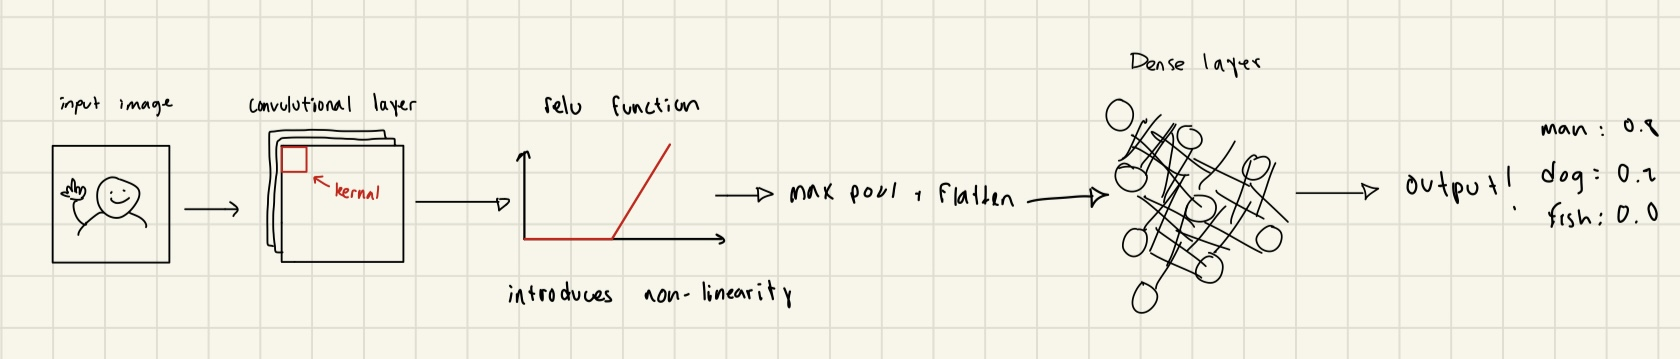

**Performance**: Run the code and report the performance of the initial model.


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = 'GTSRB-Training_fixed/GTSRB/Training'

def preprocess(img):
    return cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)

class GTSRBDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for dir in os.listdir(data_dir):
            if dir == '.DS_Store' or dir == '.ipynb_checkpoints':
                continue
            inner_dir = os.path.join(data_dir, dir)

            if not os.path.isdir(inner_dir):
                continue

            csv_file = pd.read_csv(os.path.join(inner_dir, "GT-" + dir + '.csv'), sep=';')

            for i, row in enumerate(csv_file.iterrows()):
                #if i >= 100: # i think this is the line that needs to be changed
                if i >= 100:
                    break
                img_path = os.path.join(inner_dir, row[1].Filename)
                img = cv2.imread(img_path)
                img = img[row[1]['Roi.Y1']:row[1]['Roi.Y2'], row[1]['Roi.X1']:row[1]['Roi.X2'], :]
                img = preprocess(img)

                self.data.append(img)
                self.labels.append(row[1].ClassId)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

dataset = GTSRBDataset(data_dir, transform=transform)

# Shuffle and split data
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(64 * 8 * 8, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(128, 43)

        self.dropout_fc1 = nn.Dropout(0.2)
        self.dropout_fc2 = nn.Dropout(0.2)
        self.dropout_fc3 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout_fc3(x)

        x = self.fc4(x)
        return x

# Training setup
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1, Loss: 3.5770
Epoch 2, Loss: 2.6434
Epoch 3, Loss: 1.6394
Epoch 4, Loss: 1.0526
Epoch 5, Loss: 0.6607
Epoch 6, Loss: 0.4507
Epoch 7, Loss: 0.3150
Epoch 8, Loss: 0.2352
Epoch 9, Loss: 0.1693
Epoch 10, Loss: 0.1399
Test Accuracy: 97.91%


#Epoch 1, Loss: 3.7615

#Epoch 2, Loss: 3.7594

#Epoch 3, Loss: 3.7600

#Epoch 4, Loss: 3.7431

#Epoch 5, Loss: 3.6775

#Epoch 6, Loss: 3.6487

#Epoch 7, Loss: 3.5696

#Epoch 8, Loss: 3.4856

#Epoch 9, Loss: 3.3453

#Epoch 10, Loss: 3.0118

#Test Accuracy: 18.60%

**Improving the model:**

- One way we can improve our performance is to provide the model with more \textbf{good} data to train on. Increase the number of images from each class to 20, 30, 40, 50, 60, 70, 80, 90, and 100. How does the accuracy change with data increase? You are welcome to load more images if you like, but we won't require this to keep training fairly quick. Include a graph showing accuracy vs number of images per class. For the following questions, continue using at least 100 images per class.







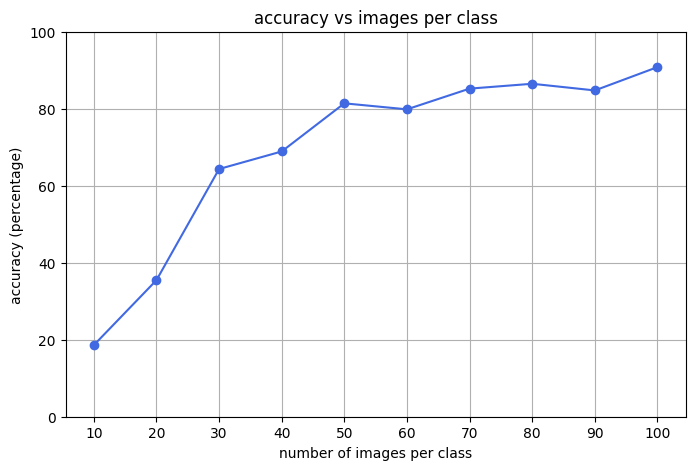

In [ ]:
# Your Plotting Code Here
# 10 images: 18.60%
# 20 images: 35.47%
# 30 images: 64.34%
# 40 images: 68.90%
# 50: 81.40%
# 60: 79.84%
# 70: 85.22%
# 80: 86.48%
# 90: 84.75%
# 10: 90.81

images_per_class = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracy = [18.60, 35.47, 64.34, 68.90, 81.40, 79.84, 85.22, 86.48, 84.75, 90.81]

plt.figure(figsize=(8, 5))
plt.plot(images_per_class, accuracy, marker='o', linestyle='-', color='royalblue')
plt.title('accuracy vs images per class')
plt.xlabel('number of images per class')
plt.ylabel('accuracy (percentage)')
plt.grid(True)
plt.xticks(images_per_class)
plt.ylim(0, 100)

plt.show()

- Another way to improve a model is to use dropout. What is dropout?

You should use nn.Dropout to add dropout in Pytorch; be careful to integrate the defined layer into the forward() function. We recommend starting with an argument of 0.2. What does the argument 0.2 represent? Add this operation after each maxpooling layer, and after each dense layer except for the last. Does the accuracy improve? Share and explain your results.

- We can further improve the model is by including batch normalization. What is batch normalization?

To add batch normalization in Pytorch, use nn.BatchNorm2d. Include this operation following every convolutional layer. Does the model accuracy improve? Share and explain your results.

# Dropout: Dropout is a technique that prevents overfitting your model by randomly dropping some neurons after each iteration of training. The 0.2 argument represents the drop rate.

# Batch Normalization: Batch normalization seeks to make training faster and more stable by adjusting the inputs to each layer and re-centering them around zero and re-scaling them to a standard size.

# Dropout results (0.2): Accuracy: 90.70%
# Dropout results (0.25): Accuracy: 85.35%

# It doesnt seem like dropout positively affects the results of the training process in a meaningful manner. I set the drop rate to 0.2, then to 0.25, and it seems that the accuracy was better when in 0.2. The model's accuracy was still lower without the dropout, though.

# Batch Normalization results: 96.98%

# Applying Batch Normalization to the training process actually vastly improved the performace of the training. Accuracy was improved by a whole 5%. Very interesting.  

## Problem 3: Semantic Segmentation

Next, we will train a neural network to perform semantic segmentation. We will use a subset of the [Cityscapes](https://www.cityscapes-dataset.com/) dataset. Most of the code below is already complete; read through the code and accompanying explanation to understand how the network functions. There are a few lines in the code which require your modification; these are noted in the instructions.

We will use the U-Net architecture introduced during class. U-Net is a type of CNN designed for quick, precise image segmentation. In the case of semantic segmentation, we are predicting a class label for every pixel in the image. Semantic segmentation is similar to object detection in that both ask the question "What objects are in this image and where in the image are those objects located?", but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic segmentation predicts a precise mask for each class.  U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. U-Net builds on the Fully Convolutional Network (FCN) architecture, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks.

The final feature layer of the FCN suffers from too much information loss due to downsampling. It then becomes difficult to upsample, causing a coarse segmentation output. U-Net improves on FCN: instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map and transposed convolutions for upsampling those maps back up to the original image size. It also adds skip connections to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information.

To begin, run the below cells to download the dataset and view and example of an image and its segmentation mask.

(*adapted from a network implementation by Alireza Heidari*)

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!pip install torch-summary
!gdown --id 11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3
!unzip Files.zip

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

path = '/content/Files/'
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')
plt.show()

In [ ]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        self.ImagesDirectory = ImagesDirectory
        self.MasksDirectory = MasksDirectory
        self.images = os.listdir(self.ImagesDirectory)
        self.masks = os.listdir(self.MasksDirectory)
        self.mask_transforms = transforms.Compose([
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST)
        ])
        self.image_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[0:3])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]

        img_path = os.path.join(self.ImagesDirectory, img_name)
        img = io.read_file(img_path)
        img = io.decode_png(img)

        mask_path = os.path.join(self.MasksDirectory, img_name)
        mask = io.read_image(mask_path)
        mask, _ = torch.max(mask[0:3], dim=0, keepdim=True)
        img, mask = self.image_transforms(img), self.mask_transforms(mask)
        return {"IMAGE": img , "MASK": mask}

EPOCHS = 30
BATCH_SIZE = 32
LR = 0.001
B1 = 0.9
B2 = 0.999

We will now examine the "contracting" or "downsampling" path of U-Net, also called the "encoder". Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, activations, and pooling layers to downsample the image and extract its features. Our implementation consists of the repeated application of two 3 x 3 convolutions, each followed by a ReLU activation and 2 x 2 max pooling operation with stride 2. At each downsampling step, the number of feature channels is doubled. We will apply Dropout to some of the convolutional blocks.

The function below will return two tensors:
* next_layer will go into the next block.
* skip_connection will be concatenated to the corresponding decoding block.

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=32, dropout_prob=0, max_pooling=True):
        """
        Convolutional downsampling block

        Arguments:
            in_ch -- Number of channels of input tensor
            n_filters -- Number of filters for the convolutional layers
            dropout_prob -- Dropout probability
            max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        """
        super().__init__()
        self.conv_1 = nn.Conv2d(in_ch, n_filters, kernel_size=(3, 3), padding=1)
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), padding=1)
        self.activation = nn.ReLU()
        self.max_pooling = max_pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) if self.max_pooling else None
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        """
        Convolutional downsampling forward

        Arguments:
            x -- Input data/batch
        Returns:
            next_layer, skip_connection --  Next layer and skip connection outputs
        """
        out = self.conv_1(x)
        out = self.activation(out)
        out = self.conv_2(out)
        out = self.activation(out)
        if self.dropout_prob > 0:
          out = self.dropout(out)

        skip_connection = out.clone()
        if self.max_pooling:
          out = self.pool(out)
        next_layer = out
        return next_layer, skip_connection

The "expanding" or "upsampling" path of U-Net, also referred to as the "decoder", performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

Each step in the expanding path upsamples the feature map with a transposed convolution. The transposed convolution halves the number of feature channels, while growing the height and width of the image.

Between the encoder and decoder, a crop function crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. We perform two 3 x 3 convolutions on this tensor, each followed by a ReLU.

In [ ]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32):
        """
        Convolutional upsampling block

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            skip_ch -- Number of channels of input tensor from previous skip layer
            n_filters -- Number of filters for the convolutional layers
        """
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_ch, in_ch//2, kernel_size=(2, 2), stride=2, padding=0)
        self.conv_1 = nn.Conv2d(in_ch // 2 + skip_ch, n_filters, kernel_size=(3, 3), padding=1)
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), padding=1)
        self.activation = nn.ReLU()

    def forward(self, expansive_input, contractive_input):
        """
        Convolutional upsampling forward

        Arguments:
            expansive_input -- Data from bottleneck or previous upsampling_block
            contractive_input -- Data from corresponding layer in the encoder
        Returns:
            conv -- Tensor output
        """
        conv = self.upsample(expansive_input)
        conv = torch.cat([conv, contractive_input], dim=1)
        conv = self.conv_1(conv)
        conv = self.activation(conv)
        conv = self.conv_2(conv)
        conv = self.activation(conv)
        return conv

In the final layer of U-Net, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

Please note that in this assignment we are only using half of the filters of the original U-Net. You are welcome to experiment with a higher number of filters to improve performance (but keep in mind the tradeoffs between model size, dataset size, and computation time).

The below cell combines the encoder and decoder. You'll need to update the number of output classes based on the downloaded Cityscapes dataset. What should this value be?

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=32, n_classes=2):
        """
        UNet Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            n_filters -- Number of filters for the convolutional layers
            n_classes -- Number of diffrent segments
        """
        super().__init__()
        self.conv_layer_1 = conv_block(in_ch, n_filters)
        self.conv_layer_2 = conv_block(n_filters, n_filters*2)
        self.conv_layer_3 = conv_block(n_filters*2,  n_filters*4)
        self.conv_layer_4 = conv_block(n_filters*4, n_filters*8, dropout_prob=0.3)
        self.conv_layer_5 = conv_block(n_filters*8, n_filters*16, dropout_prob=0.3, max_pooling=False)

        self.upsample_layer_1 = upsampling_block(n_filters*16, n_filters*8, n_filters * 8)
        self.upsample_layer_2 = upsampling_block(n_filters*8, n_filters*4, n_filters * 4)
        self.upsample_layer_3 = upsampling_block(n_filters*4, n_filters*2, n_filters * 2)
        self.upsample_layer_4 = upsampling_block(n_filters*2, n_filters*1, n_filters * 1)

        self.last_conv = nn.Sequential(
            nn.Conv2d(n_filters, n_filters,  kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_classes,  kernel_size=(1, 1), padding=0),
        )

    def forward(self, x):
        """
        UNet forward

        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """
        conv_1_next, conv_1_skip = self.conv_layer_1(x)
        conv_2_next, conv_2_skip = self.conv_layer_2(conv_1_next)
        conv_3_next, conv_3_skip = self.conv_layer_3(conv_2_next)
        conv_4_next, conv_4_skip = self.conv_layer_4(conv_3_next)
        conv_5_next, conv_5_skip = self.conv_layer_5(conv_4_next)

        out = self.upsample_layer_1(conv_5_next, conv_4_skip)
        out = self.upsample_layer_2(out, conv_3_skip)
        out = self.upsample_layer_3(out, conv_2_skip)
        out = self.upsample_layer_4(out, conv_1_skip)

        out = self.last_conv(out)
        return out

in_channels = 3
n_filters = 32
n_classes = 43 # What should this value be? Update this value according to the dataset.
unet = UNet(in_channels, n_filters, n_classes).to(device)
summary(unet, (3, 192, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─conv_block: 1-1                        [-1, 32, 96, 128]         --
|    └─Conv2d: 2-1                       [-1, 32, 192, 256]        896
|    └─ReLU: 2-2                         [-1, 32, 192, 256]        --
|    └─Conv2d: 2-3                       [-1, 32, 192, 256]        9,248
|    └─ReLU: 2-4                         [-1, 32, 192, 256]        --
|    └─MaxPool2d: 2-5                    [-1, 32, 96, 128]         --
├─conv_block: 1-2                        [-1, 64, 48, 64]          --
|    └─Conv2d: 2-6                       [-1, 64, 96, 128]         18,496
|    └─ReLU: 2-7                         [-1, 64, 96, 128]         --
|    └─Conv2d: 2-8                       [-1, 64, 96, 128]         36,928
|    └─ReLU: 2-9                         [-1, 64, 96, 128]         --
|    └─MaxPool2d: 2-10                   [-1, 64, 48, 64]          --
├─conv_block: 1-3                        [-1, 128, 24, 32]         --
|  

Layer (type:depth-idx)                   Output Shape              Param #
├─conv_block: 1-1                        [-1, 32, 96, 128]         --
|    └─Conv2d: 2-1                       [-1, 32, 192, 256]        896
|    └─ReLU: 2-2                         [-1, 32, 192, 256]        --
|    └─Conv2d: 2-3                       [-1, 32, 192, 256]        9,248
|    └─ReLU: 2-4                         [-1, 32, 192, 256]        --
|    └─MaxPool2d: 2-5                    [-1, 32, 96, 128]         --
├─conv_block: 1-2                        [-1, 64, 48, 64]          --
|    └─Conv2d: 2-6                       [-1, 64, 96, 128]         18,496
|    └─ReLU: 2-7                         [-1, 64, 96, 128]         --
|    └─Conv2d: 2-8                       [-1, 64, 96, 128]         36,928
|    └─ReLU: 2-9                         [-1, 64, 96, 128]         --
|    └─MaxPool2d: 2-10                   [-1, 64, 48, 64]          --
├─conv_block: 1-3                        [-1, 128, 24, 32]         --
|  

The below function allows you to display an input image and its ground truth mask (the goal of your model).

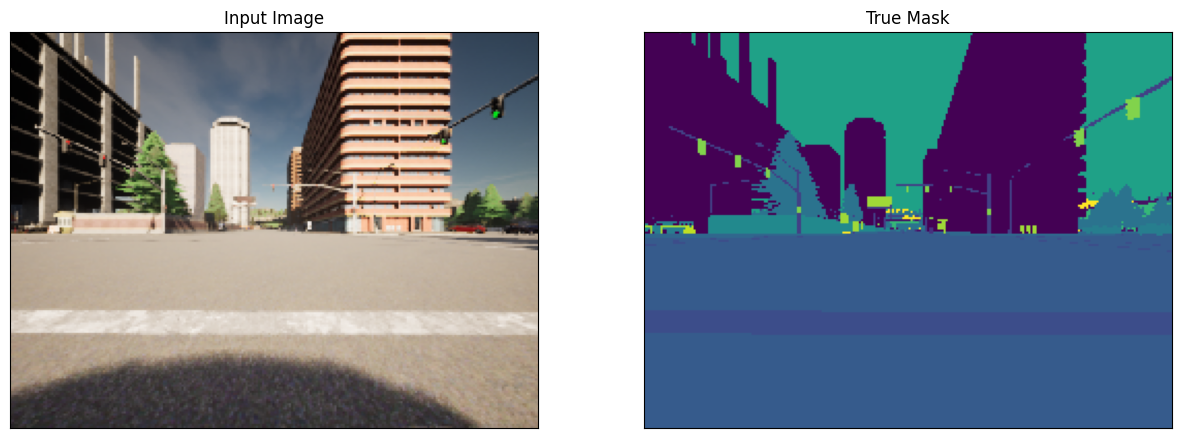

In [ ]:
dataloader = DataLoader(Segmentation_Dataset(image_path, mask_path), batch_size=BATCH_SIZE, shuffle=True)

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].permute(1, 2, 0))
        plt.axis('off')
    return plt

batch = next(iter(dataloader))
image = batch['IMAGE'][0, :, :, :]
mask =  batch['MASK'][0, :, :, :]

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

axs[0].imshow(np.transpose(image, (1, 2, 0)))
axs[0].set_title('Input Image')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(np.transpose(mask, (1, 2, 0)))
axs[1].set_title('True Mask')
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.show()

In this dataset, each pixel of a mask is assigned a single integer representing its class index. The pytorch CrossEntropyLoss function is equipped to handle this type of input in a computationally efficient way.

In the below cell, we train the network, then we define a function that uses torch.argmax in the axis of the number of classes to return the index with the largest value as the output image.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2))

losses = []
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(dataloader):
        images = batch['IMAGE'].to(device)
        masks = batch['MASK'].to(device)
        N, C, H, W = masks.shape
        masks = masks.reshape((N, H, W)).long()
        # masks = torch.argmax(masks, dim=1).long()

        optimizer.zero_grad()

        outputs = unet(images)

        # Compute loss
        loss = criterion(outputs, masks)
        epoch_losses.append(loss.item() * images.size(0))

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        print(f'EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}')
    losses.append(np.mean(epoch_losses) / len(dataloader.dataset))

def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, dim=1).detach()
    return pred_mask

In the below cell, plot the network training losses and comment on the training. Has the network seemed to converge?

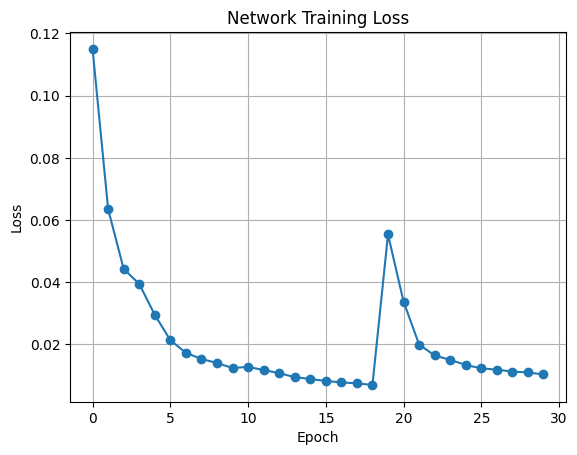

In [ ]:
# Your Code Here
plt.plot(losses, marker="o")
plt.title("Network Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# At around Epoch 19, the loss skyrockets from what was a pretty low point. This seems to suggest overfitting. From 20 onwards, however, it gradually restabilizes.

The below cell allows us to visualize our network predictions compared to the ground truth. How did your network do? Based on principles we have discussed during class, suggest two ways that you might improve the performance of your neural network on this important segmentation task.

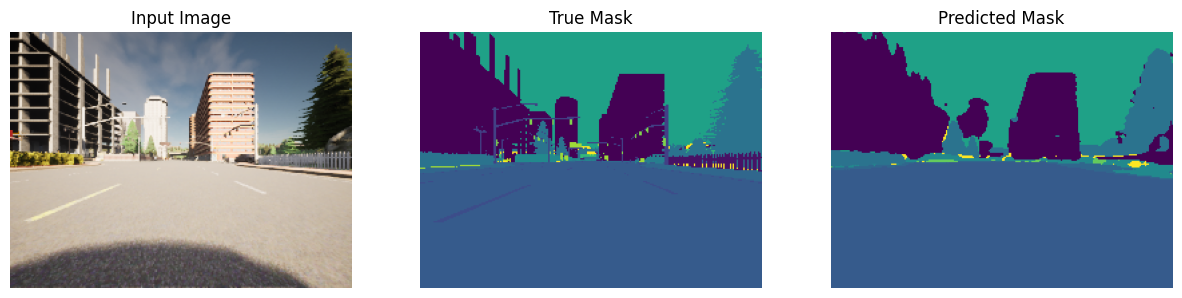

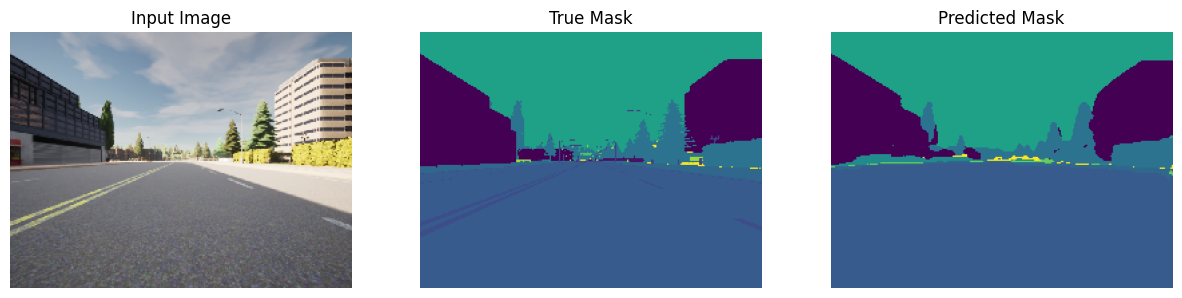

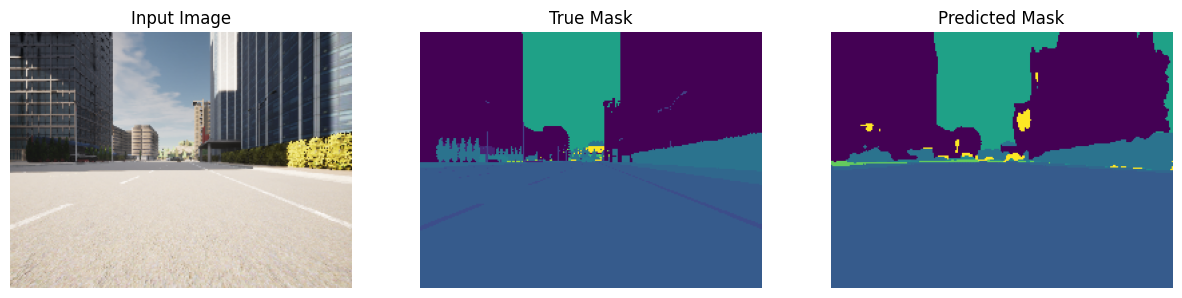

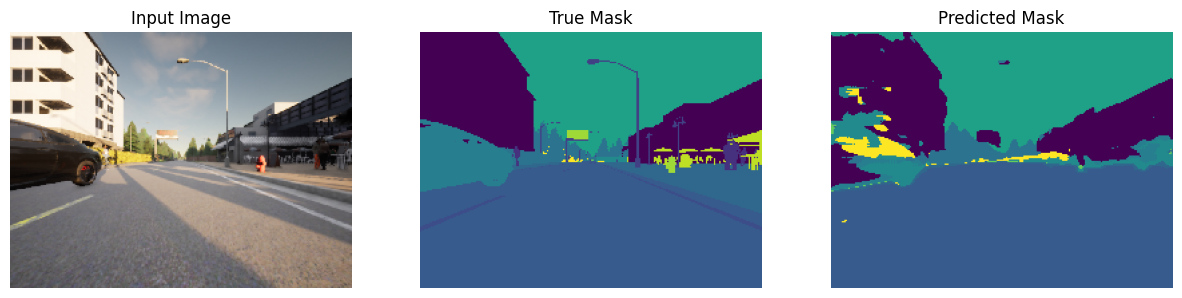

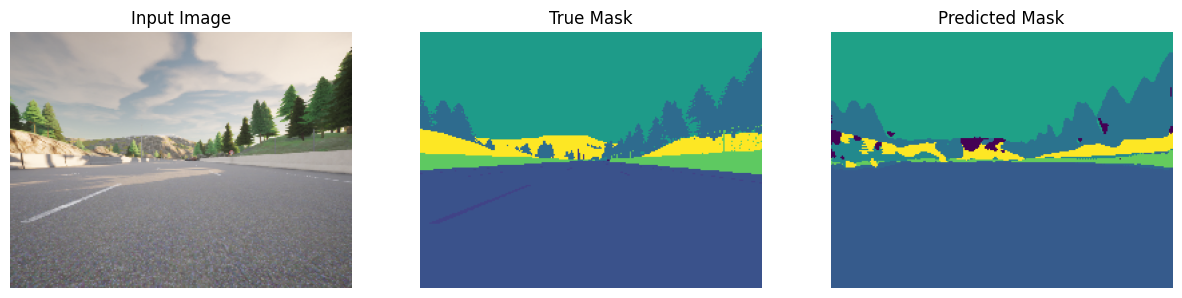

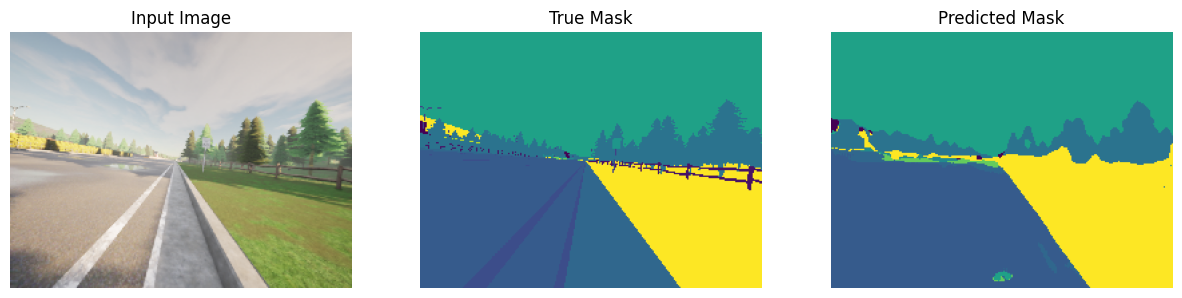

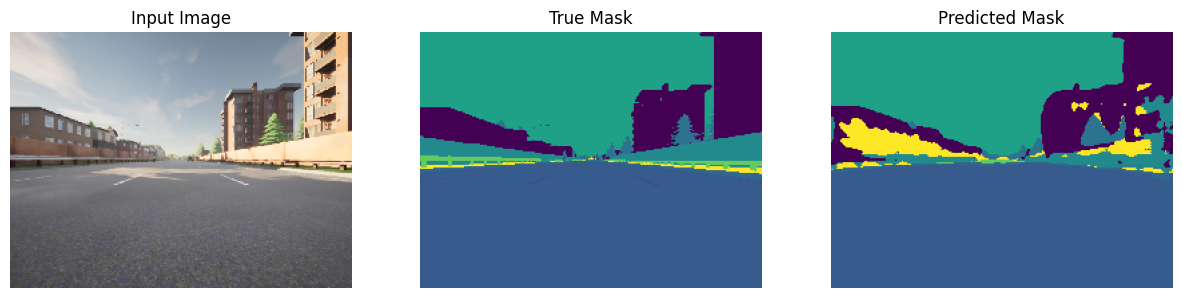

In [ ]:
def show_predictions(dataloader, device, num=1):
    """
    Displays the first image of each of the num batches
    """
    for i, batch in enumerate(dataloader):
        IMG = batch["IMAGE"][0, :, : ,:].to(device).unsqueeze(0)
        MASK = batch["MASK"][0, :, :, :].to(device).unsqueeze(0)
        pred_mask = unet.to(device)(IMG)
        display([IMG[0].cpu(), MASK[0].cpu(), create_mask(pred_mask).cpu()]).show()

        if i >= num:
            break

show_predictions(dataloader, device, 6)

# My network did not do horribly, however, in most of the images there were objects that it failed to pick up. Sometimes an object would be picked up as multiple classes, like the car in these photos, and would end up being segmented into a blob.

# 2 ways that could improve the network's performance: 1) Larger training sets. With a larger training set, the network will have more to learn from and will be exposed to more varying angles and scenarios.

# 2) You can more finely tune the hyperparameters. This would affect the learning rate, dropout rate, batch size, etc. If you found a sweet spot it would probably improve your network a lot.